# [프로젝트] 딥러닝 모델을 활용한 데이터 회귀분석 및 이상탐지


## 1. 콘크리트 배합 데이터셋

페이스북, 인스타그램, 스레드로 유명한 기업 Meta에서는 강하고 친환경적인 콘크리트를 생산하는 인공지능 모델을 만들어 탄소 배출량을 40% 줄였다고 발표하였습니다.
* [데이터셋 관련 뉴스](https://www.engadget.com/metas-newest-ai-discovers-stronger-and-greener-concrete-formulas-190001332.html)

위의 뉴스를 잘 읽어보면 메타는 인공지능 모델을 학습시키기 위해 1030개의 콘크리트 배합 데이터를 활용했다고 합니다. 이번 실습에서는 이 데이터를 딥러닝을 활용해서 분석해보도록 하겠습니다.

### 1-1. 필요한 라이브러리 import

In [ ]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 관련
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 딥러닝 관련
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, SimpleRNN, LSTM

# Keras 모델 시각화
from keras.utils import plot_model

### 1-2. 데이터 불러오기

In [ ]:
# Load Data
con_df = pd.read_csv("data/concrete_data.csv")
con_df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [ ]:
# con_df 상위 5개의 데이터 확인
con_df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### 1-3. 데이터 EDA (Exploratory Data Analysis)

지난 실습들을 통해 충분히 아는 데이터이기 때문에 결측치가 없는 것만 확인 후 바로 딥러닝에 적용해 볼 수 있도록 하겠습니다.

In [ ]:
# con_df 내 Column 별 정보 확인
con_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [ ]:
con_df.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

결측치가 con_df 데이터에는 존재하지 않아서, 이제 바로 딥러닝을 적용해볼 수 있겠습니다.

### 1-4. MLP을 활용한 콘크리트 강도 예측

딥러닝 (Deep Learning)은 인공신경망 (Artificial Neural Network)을 기반으로 한 머신러닝 알고리즘의 한 종류입니다. 딥러닝은 다층 신경망 (Multi-Layer Perceptron, MLP)을 사용하여 복잡한 문제를 해결하고 데이터로부터 의미 있는 특징을 추출하는 능력을 갖추고 있습니다. 사람의 뉴런처럼 연결된 여러개의 신경망이 수학적 연산을 통해 값을 출력합니다.

다층 신경망(MLP)은 입력 층 (input layer), 은닉 층 (hidden layer), 출력 층 (output layer) 등으로 구성된 인공신경망 구조입니다. 각 층은 여러 개의 뉴런 또는 노드로 구성되어 있으며, 각 뉴런은 가중치와 활성화 함수를 가지고 있습니다. 입력층은 데이터를 받아들이고, 은닉층은 중간 계산을 수행하고, 출력층은 최종 결과를 출력합니다.

#### 1-4-1. Train / Test Data Split
학습데이터를 준비합니다.

In [ ]:
# df 변수에 concrete_data.csv 데이터 할당
df = pd.read_csv("data/concrete_data.csv")

# 독립 변수와 종속 변수 분리
X = df.drop('Strength', axis=1)
y = df['Strength']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

학습 데이터와 테스트 데이터를 분리한 다음 MLP 모델을 구현해보겠습니다.

위의 MLP 모델은 입력 층과 2개의 은닉 층 (64개와 128개의 뉴런) 그리고 출력 층으로 구성되어 있습니다.

위의 모델은 주어진 데이터를 학습하여 회귀(Regression) 작업을 수행하고 있습니다.

#### 1-4-2. MLP 모델 구성

이어서 모델을 만들어줍니다. Tensorflow의 keras Sequential API를 사용해보겠습니다.

In [ ]:
# MLP 모델 구성

# Sequential() 로 모델 정의
MLP = Sequential()

# 입력층에서는 input_shape 을 통해 데이터를 넣어줍니다.
MLP.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden Layer 1
MLP.add(Dense(128, activation='relu'))

# Hidden Layer 2
MLP.add(Dense(64, activation='relu'))

# 출력 층에서 이진 분류 () 를 '적합', 부적합' 으로 이진 분류를 해주기 때문에 최종 출력은 1로 설정해줍니다.
MLP.add(Dense(1))

MLP.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (67.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


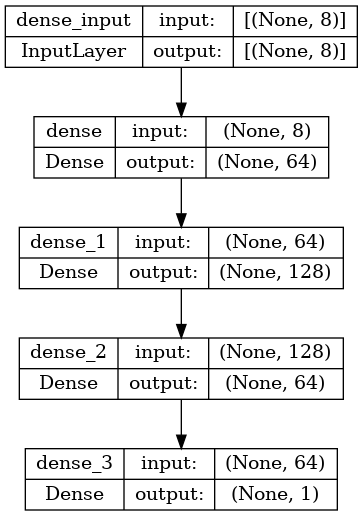

In [ ]:
# Sequential 모델의 구조 시각화
plot_model(MLP, show_shapes=True, show_layer_names=True)


MLP 모델을 구현했습니다.

#### 1-4-3. MLP 모델 학습

**[TODO] 이제 데이터를 학습시켜 보도록 하겠습니다.**

In [ ]:
# 모델 컴파일
MLP.compile(optimizer='adam', loss='mean_squared_error')
# 'adam' 옵티마이저를 사용하여 모델을 컴파일
# 손실 함수로는 평균 제곱 오차 (mean_squared_error)를 사용

# 모델 학습
MLP_history = MLP.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))
# X_train과 y_train 데이터를 사용하여 모델을 학습
# epochs=100은 전체 데이터셋을 100번 반복하여 학습하라는 의미
# batch_size=32는 한 번에 32개의 샘플을 사용하여 가중치를 업데이트하라는 의미
# verbose=1은 학습 과정을 출력하는 설정으로, 진행 상황이 표시됩니다.

Epoch 1/100
26/26 [==============================] - 1s 10ms/step - loss: 380.2297 - val_loss: 173.3432
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 147.0247 - val_loss: 103.3396
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 110.5797 - val_loss: 91.9898
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 113.3469 - val_loss: 90.1208
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 119.5321 - val_loss: 91.0760
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 96.4617 - val_loss: 68.2614
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 84.3846 - val_loss: 62.1386
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 90.4501 - val_loss: 63.0979
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss: 68.0243 - val_loss: 62.8442
Epoch 10/100
26/26 [==============================] - 0s 3ms/step - loss: 62.2540 -

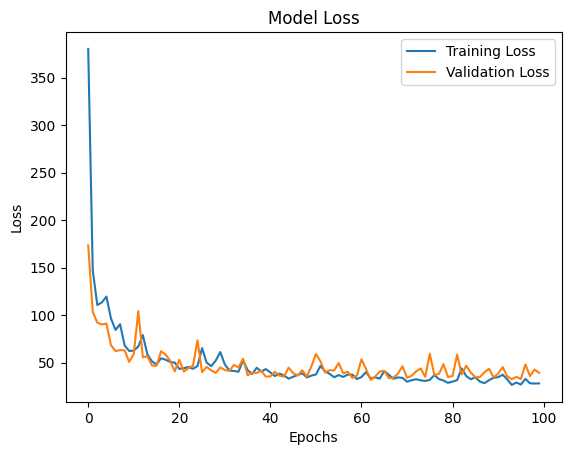

In [ ]:
# MLP Loss 그래프
plt.plot(MLP_history.history['loss'], label='Training Loss')
plt.plot(MLP_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

#### 1-4-4. MLP 모델 성능 예측

콘크리트 강도 예측 결과를 확인해보겠습니다.

In [ ]:
# 테스트 데이터로 예측
# 학습된 모델을 사용하여 X_test 데이터에 대한 예측값을 얻음
y_pred = MLP.predict(X_test)

# 예측 결과 평가
mlp_mse = mean_squared_error(y_test, y_pred)  # 예측 결과와 실제 값 간의 평균 제곱 오차 계산
mlp_mae = mean_absolute_error(y_test, y_pred)  # 예측 결과와 실제 값 간의 평균 절대 오차 계산

# 계산된 평균 제곱 오차와 평균 절대 오차를 출력
print("Mean Squared Error :", mlp_mse)
print("Mean Absolute Error :", mlp_mae)

7/7 [==============================] - 0s 2ms/step
Mean Squared Error : 39.22088779466222
Mean Absolute Error : 4.7226242312644295


총 100번의 학습(epochs)를 수행하여 최종적으로 콘크리트의 강도를 예측하는 딥러닝 모델을 완성하였습니다.

1. Mean Squared Error (평균 제곱 오차)

- Mean Squared Error(MSE)는 예측값과 실제값 사이의 차이(오차)를 제곱한 후 평균을 구한 값입니다.
- MSE 값이 약 34.034로 나왔습니다. 이 값이 작을수록 예측이 더 정확하다는 것을 의미합니다. 하지만 실제 값과 예측 값의 스케일에 따라 해석이 달라지므로, 데이터의 특성에 맞게 해석해야 합니다.

2. Mean Absolute Error (평균 절대 오차)

- Mean Absolute Error(MAE)는 예측값과 실제값 사이의 차이의 절대값을 평균한 값입니다.
- MAE 값이 약 4.43으로 나왔습니다. MSE와 달리 제곱을 하지 않기 때문에 실제 오차 크기를 직접 파악할 수 있습니다.
- MAE 값이 작을수록 예측이 더 정확하다는 것을 의미합니다.

따라서 이 모델은 주어진 데이터에 대해 상대적으로 정확한 예측을 수행하는 것으로 보입니다.

지금은 단순히 Layer 를 쌓은 것이고, 이후에 CNN, RNN, LSTM 을 활용함으로써 성능 차이가 어떻게 있는 지 확인해보도록 하겠습니다.

### 1-5. CNN을 활용한 콘크리트 강도 예측

이번에는 CNN 모델을 활용해서 실습을 진행해보고, 콘크리트 예측 성능을 확인해보도록 하겠습니다.

#### 1-5-1. Train / Test Data Split & Reshape

In [ ]:
# pandas를 사용하여 concrete_data.csv 파일을 DataFrame으로 불러옴
df = pd.read_csv("data/concrete_data.csv")

# 독립 변수와 종속 변수 분리
X = df.drop('Strength', axis=1)  # 'Strength' 열을 제외한 열들을 독립 변수로 설정
y = df['Strength']  # 'Strength' 열을 종속 변수로 설정

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 입력 데이터의 형태 변환 (2D로 reshape)
# 입력 데이터의 형태를 2차원에서 3차원으로 변환 (Conv1D 모델을 위해)
# 각각의 데이터 포인트는 X_train.shape[1] 개의 feature를 가지며, 1개의 채널을 갖는 형태로 변환됨
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)


#### 1-5-2. CNN 모델 구성

In [ ]:
# 1D CNN 모델 구성
CNN = Sequential()  # Sequential 모델 생성

# Convolutional layer 추가
CNN.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# 64개의 필터를 사용하는 Convolutional 레이어 추가
# kernel_size=3은 필터의 크기를 3으로 설정
# activation='relu'는 활성화 함수로 ReLU를 사용
# input_shape=(X_train.shape[1], 1)은 입력 데이터의 형태를 설정 (열 수, 1차원)

# MaxPooling 레이어 추가
CNN.add(MaxPooling1D(pool_size=2))
# pool_size=2는 MaxPooling을 2개씩 묶어서 진행

# 데이터를 1차원으로 평탄화
CNN.add(Flatten())

# Fully Connected 레이어 추가
CNN.add(Dense(128, activation='relu'))
CNN.add(Dense(64, activation='relu'))

# 출력 레이어 추가
CNN.add(Dense(1))

# CNN 모델 요약 정보 출력
CNN.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               24704     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                      

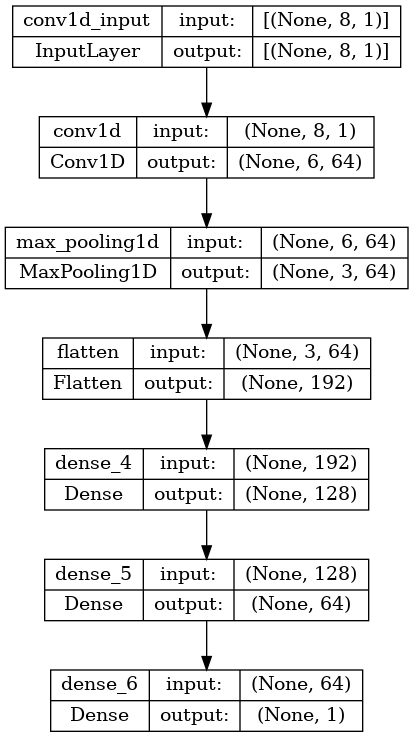

In [ ]:
# 모델 구성 시각화
plot_model(CNN, show_shapes=True, show_layer_names=True)


간단한 CNN 모델을 구현했습니다.

#### 1-5-3. CNN 모델 학습

**[TODO]이제 데이터를 학습시켜 보도록 하겠습니다.**

In [ ]:
# 모델 컴파일
# 'adam' 옵티마이저를 사용하여 모델을 컴파일
# 손실 함수로는 평균 제곱 오차 (mean_squared_error)를 사용
CNN.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
CNN_history = CNN.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))
# 3차원 형태로 변환된 X_train과 y_train 데이터를 사용하여 모델을 학습
# epochs=100은 전체 데이터셋을 100번 반복하여 학습하라는 의미
# batch_size=32는 한 번에 32개의 샘플을 사용하여 가중치를 업데이트하라는 의미
# verbose=1은 학습 과정을 출력하는 설정으로, 진행 상황이 표시됩니다.

Epoch 1/100
26/26 [==============================] - 1s 10ms/step - loss: 861.4379 - val_loss: 272.2813
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 256.4550 - val_loss: 281.9991
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 240.3128 - val_loss: 200.4870
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 187.6840 - val_loss: 187.1374
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 170.2999 - val_loss: 130.1666
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 134.1713 - val_loss: 109.6924
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 129.2337 - val_loss: 101.0440
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 117.4490 - val_loss: 101.0029
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 106.5172 - val_loss: 88.3747
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss:

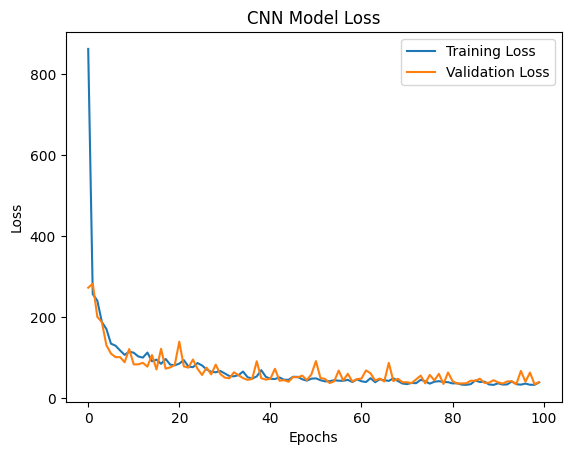

In [ ]:
# CNN Loss 그래프
plt.plot(CNN_history.history['loss'], label='Training Loss')
plt.plot(CNN_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.legend()
plt.show()

#### 1-5-4. CNN 모델 성능 예측

콘크리트 강도 예측 결과를 확인해보겠습니다.

In [ ]:
# 테스트 데이터로 예측
# 학습된 모델을 사용하여 3차원 형태로 변환된 X_test 데이터에 대한 예측값을 얻음
y_pred = CNN.predict(X_test)

# 예측 결과 평가
cnn_mse = mean_squared_error(y_test, y_pred)  # 예측 결과와 실제 값 간의 평균 제곱 오차 계산
cnn_mae = mean_absolute_error(y_test, y_pred)  # 예측 결과와 실제 값 간의 평균 절대 오차 계산

# 계산된 평균 제곱 오차와 평균 절대 오차를 출력
print("Mean Squared Error:", cnn_mse)
print("Mean Absolute Error:", cnn_mae)

7/7 [==============================] - 0s 2ms/step
Mean Squared Error: 39.31463484388583
Mean Absolute Error: 5.004156976903527


### 1-6. RNN을 활용한 콘크리트 강도 예측

이번에는 RNN 모델을 활용해서 실습을 진행해보고, 콘크리트 예측 성능을 확인해보도록 하겠습니다.

#### 1-6-1. Train / Test Data Split & Reshape

In [ ]:
# pandas를 사용하여 concrete_data.csv 파일을 DataFrame으로 불러옴
df = pd.read_csv("data/concrete_data.csv")

# 독립 변수와 종속 변수 분리
X = df.drop('Strength', axis=1)  # 'Strength' 열을 제외한 열들을 독립 변수로 설정
y = df['Strength']  # 'Strength' 열을 종속 변수로 설정

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train과 X_test를 RNN용으로 변환
# SimpleRNN 레이어에 입력하기 위해 3차원 형태로 데이터를 변환합니다.
# SimpleRNN은 1D 시퀀스 데이터를 처리하는 레이어로, 각 시퀀스의 값은 1개로 이루어진 1D 데이터입니다.
X_train_rnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)


#### 1-6-2. RNN 모델 구성

**[TODO] RNN 모델을 구현합니다.**

In [ ]:
# RNN 모델 구성
# Sequential 모델을 사용하여 레이어를 순차적으로 쌓아 모델을 구성합니다.
RNN = Sequential()

# SimpleRNN 레이어를 추가합니다.
# 32개의 뉴런을 가진 SimpleRNN 레이어를 생성하고, 활성화 함수로 ReLU를 사용합니다.
RNN.add(SimpleRNN(32, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))

# Fully Connected 레이어를 추가합니다.
# 64개의 뉴런을 가진 Hidden Layer를 생성하고, 활성화 함수로 ReLU를 사용합니다.
RNN.add(Dense(64, activation='relu'))

# 출력 레이어를 추가합니다.
# 1개의 뉴런을 가진 출력 레이어를 생성합니다.
RNN.add(Dense(1))

# 모델의 구성 요약을 출력합니다.
RNN.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3265 (12.75 KB)
Trainable params: 3265 (12.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


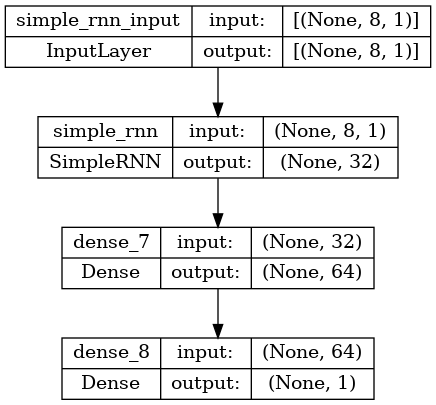

In [ ]:
# Sequential 모델의 구조 시각화
plot_model(RNN, show_shapes=True, show_layer_names=True)


#### 1-6-3. RNN 모델 학습

이제 데이터를 학습시켜 보도록 하겠습니다.

In [ ]:
# 모델 컴파일
RNN.compile(optimizer='adam', loss='mean_squared_error')
# 'adam' 옵티마이저를 사용하고, 손실 함수로 'mean_squared_error'를 사용하여 RNN 모델을 컴파일합니다.
# 'mean_squared_error'는 평균 제곱 오차를 최소화하는 손실 함수입니다.

# 모델 학습
RNN_history = RNN.fit(X_train_rnn, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_rnn, y_test))
# X_train_rnn과 y_train 데이터를 사용하여 RNN 모델을 학습합니다.
# epochs=100은 전체 데이터셋을 100번 반복하여 학습하는 것을 의미합니다.
# batch_size=32는 한 번의 반복에서 32개의 데이터를 사용하여 가중치를 업데이트하는 것을 의미합니다.
# verbose=1은 학습 과정을 출력합니다.

Epoch 1/100
26/26 [==============================] - 2s 12ms/step - loss: 911.2847 - val_loss: 335.9341
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 290.0544 - val_loss: 232.6176
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 247.3764 - val_loss: 212.9001
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 230.7643 - val_loss: 205.2515
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 222.6848 - val_loss: 197.7485
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 209.1969 - val_loss: 187.2290
Epoch 7/100
26/26 [==============================] - 0s 4ms/step - loss: 189.5590 - val_loss: 160.8402
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 157.7614 - val_loss: 138.2321
Epoch 9/100
26/26 [==============================] - 0s 4ms/step - loss: 136.5359 - val_loss: 119.8529
Epoch 10/100
26/26 [==============================] - 0s 4ms/step - loss

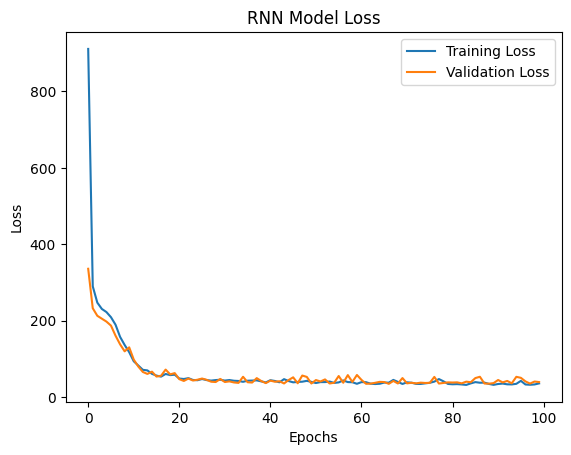

In [ ]:
# RNN Loss 그래프
plt.plot(RNN_history.history['loss'], label='Training Loss')
plt.plot(RNN_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model Loss')
plt.legend()
plt.show()

#### 1-6-4. RNN 모델 성능 예측

콘크리트 강도 예측 결과를 확인해보겠습니다.

In [ ]:
# 테스트 데이터로 예측
# X_test 데이터를 사용하여 RNN 모델이 예측한 결과를 얻습니다.
y_pred_rnn = RNN.predict(X_test)

# 예측 결과 평가
rnn_mse = mean_squared_error(y_test, y_pred_rnn)   # 예측 결과와 실제 값 간의 평균 제곱 오차 계산
rnn_mae = mean_absolute_error(y_test, y_pred_rnn)  # 예측 결과와 실제 값 간의 평균 절대 오차 계산

# 계산된 평균 제곱 오차와 평균 절대 오차를 출력
print("RNN - Mean Squared Error:", rnn_mse)
print("RNN - Mean Absolute Error:", rnn_mae)


7/7 [==============================] - 0s 2ms/step
RNN - Mean Squared Error: 39.418038037082155
RNN - Mean Absolute Error: 5.1120506786605695


### 2-7. LSTM을 활용한 콘크리트 강도 예측

이번에는 LSTM 모델을 활용해서 실습을 진행해보고, 콘크리트 예측 성능을 확인해보도록 하겠습니다.

#### 1-7-1. Train / Test Data Split & Reshape

In [ ]:
# pandas를 사용하여 concrete_data.csv 파일을 DataFrame으로 불러옴
df = pd.read_csv("data/concrete_data.csv")

# 독립 변수와 종속 변수 분리
X = df.drop('Strength', axis=1)  # 'Strength' 열을 제외한 열들을 독립 변수로 설정
y = df['Strength']  # 'Strength' 열을 종속 변수로 설정

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train과 X_test를 LSTM용으로 변환
# LSTM 레이어에 입력하기 위해 3차원 형태로 데이터를 변환합니다.
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

#### 1-7-2. LSTM 모델 구성

In [ ]:
# LSTM 모델 구성
# Sequential 모델을 사용하여 레이어를 순차적으로 쌓아 모델을 구성합니다.
LSTM_model = Sequential()

# LSTM 레이어를 추가합니다.
# 32개의 뉴런을 가진 LSTM 레이어를 생성하고, 활성화 함수로 ReLU를 사용합니다.
LSTM_model.add(LSTM(32, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# Fully Connected 레이어를 추가합니다.
# 64개의 뉴런을 가진 Hidden Layer를 생성하고, 활성화 함수로 ReLU를 사용합니다.
LSTM_model.add(Dense(64, activation='relu'))

# 출력 레이어를 추가합니다.
# 1개의 뉴런을 가진 출력 레이어를 생성합니다.
LSTM_model.add(Dense(1))

# 모델의 구성 요약을 출력합니다.
LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6529 (25.50 KB)
Trainable params: 6529 (25.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 1-7-3. LSTM 모델 학습

이제 데이터를 학습시켜 보도록 하겠습니다.

In [ ]:
# 모델 컴파일
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
# 'adam' 옵티마이저를 사용하고, 손실 함수로 'mean_squared_error'를 사용하여 LSTM 모델을 컴파일합니다.
# 'mean_squared_error'는 평균 제곱 오차를 최소화하는 손실 함수입니다.

# 모델 학습
LSTM_history = LSTM_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_lstm, y_test))
# X_train_lstm과 y_train 데이터를 사용하여 LSTM 모델을 학습합니다.
# epochs=100은 전체 데이터셋을 100번 반복하여 학습하는 것을 의미합니다.
# batch_size=32는 한 번의 반복에서 32개의 데이터를 사용하여 가중치를 업데이트하는 것을 의미합니다.
# verbose=1은 학습 과정을 출력합니다.

Epoch 1/100
26/26 [==============================] - 2s 13ms/step - loss: 2079.3154 - val_loss: 993.8386
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 492.7993 - val_loss: 304.9928
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 217.4721 - val_loss: 139.9547
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 137.6916 - val_loss: 95.7473
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 111.4910 - val_loss: 95.8025
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 88.7513 - val_loss: 78.9496
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 68.9471 - val_loss: 63.3122
Epoch 8/100
26/26 [==============================] - 0s 4ms/step - loss: 63.7584 - val_loss: 63.5828
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 58.9894 - val_loss: 61.5704
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 53.3565

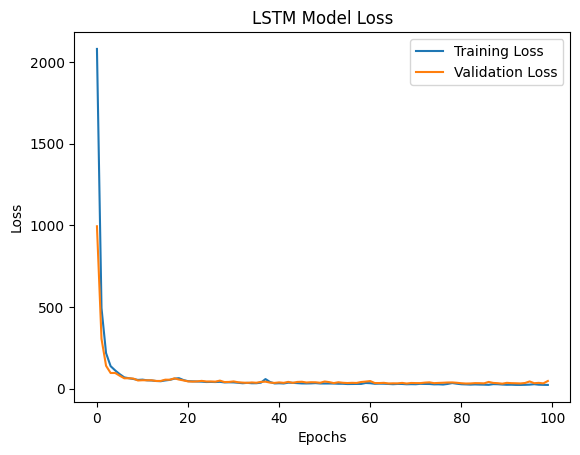

In [ ]:
# LSTM_model Loss 그래프
plt.plot(LSTM_history.history['loss'], label='Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')
plt.legend()
plt.show()


#### 1-7-4. LSTM 모델 성능 예측

콘크리트 강도 예측 결과를 확인해보겠습니다.

In [ ]:
# 테스트 데이터로 예측
# X_test_lstm 데이터를 사용하여 LSTM 모델이 예측한 결과를 얻습니다.
y_pred_lstm = LSTM_model.predict(X_test_lstm)

# 예측 결과 평가
lstm_mse = mean_squared_error(y_test, y_pred_lstm)   # 예측 결과와 실제 값 간의 평균 제곱 오차 계산
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)   # 예측 결과와 실제 값 간의 평균 절대 오차 계산

# 계산된 평균 제곱 오차와 평균 절대 오차를 출력
print("LSTM - Mean Squared Error:", lstm_mse)
print("LSTM - Mean Absolute Error:", lstm_mae)

7/7 [==============================] - 0s 2ms/step
LSTM - Mean Squared Error: 46.72141606461705
LSTM - Mean Absolute Error: 5.249083726938489


### 1-8. 딥러닝 모델 별 성능 비교


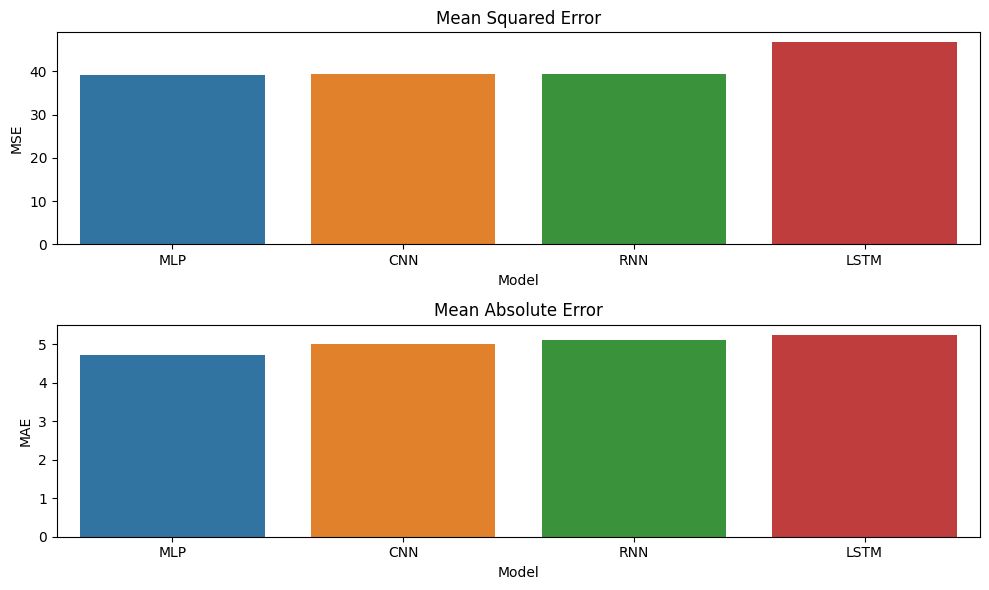

----------------
MLP - Mean Squared Error: 39.22088779466222
MLP - Mean Absolute Error: 4.7226242312644295
----------------
CNN - Mean Squared Error: 39.31463484388583
CNN - Mean Absolute Error: 5.004156976903527
----------------
RNN - Mean Squared Error: 39.418038037082155
RNN - Mean Absolute Error: 5.1120506786605695
----------------
LSTM - Mean Squared Error: 46.72141606461705
LSTM - Mean Absolute Error: 5.249083726938489


In [ ]:
# 딥러닝 모델 별 성능 비교
models = ['MLP', 'CNN', 'RNN', 'LSTM']
mse_scores = [mlp_mse, cnn_mse, rnn_mse, lstm_mse]  # 임의의 평균 제곱 오차 값
mae_scores = [mlp_mae, cnn_mae, rnn_mae, lstm_mae]   # 임의의 평균 절대 오차 값

# 평가 지표 데이터를 데이터프레임으로 정리
import pandas as pd
data = {'Model': models, 'MSE': mse_scores, 'MAE': mae_scores}
df_scores = pd.DataFrame(data)

# 성능 지표를 시각화
plt.figure(figsize=(10, 6))

# 평균 제곱 오차 (MSE)
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='MSE', data=df_scores)
plt.title('Mean Squared Error')

# 평균 절대 오차 (MAE)
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='MAE', data=df_scores)
plt.title('Mean Absolute Error')

plt.tight_layout()
plt.show()

print("----------------")

# MLP - MSE, MAE
print("MLP - Mean Squared Error:", mlp_mse)
print("MLP - Mean Absolute Error:", mlp_mae)

print("----------------")

# CNN - MSE, MAE
print("CNN - Mean Squared Error:", cnn_mse)
print("CNN - Mean Absolute Error:", cnn_mae)

print("----------------")

# RNN - MSE, MAE
print("RNN - Mean Squared Error:", rnn_mse)
print("RNN - Mean Absolute Error:", rnn_mae)

print("----------------")

# LSTM - MSE, MAE
print("LSTM - Mean Squared Error:", lstm_mse)
print("LSTM - Mean Absolute Error:", lstm_mae)

이렇게 콘크리트 데이터셋을 활용한 데이터 분석부터 머신러닝, 딥러닝 모델을 활용한 예측까지를 수행해보았습니다.

## 2. 딥러닝 모델을 활용한 모터 베어링 데이터 이상탐지

## 실습 목표

- 실제로 수집된 베어링 데이터셋을 데이터 특징 추출 및 전처리 과정을 학습합니다.
- 주어진 자료로부터 베어링의 상태를 예측합니다.

---

## 2-1. 데이터 준비하기

이전 시간과 마찬가지로 딥러닝 학습 데이터를 준비합니다.
데이터의 특성은 다음과 같습니다.

https://www.kaggle.com/datasets/isaienkov/bearing-classification?resource=download&select=bearing_signals.csv

- bearing_signals.csv : 신호 녹음 정보를 담고 있습니다.
- bearing_classes.csv : 각 베어링에 대한 완전한 상태 또는 불량한 상태의 클래스 정보를 포함하고 있습니다.

1) 축의 회전 속도는 0~1500 rpm 사이의 값을 가지는데, 10초 동안 유지된 후 250 rpm으로 감소합니다.  
2) 축은 DC 모터를 사용하여 회전합니다.  
3) 축에는 3.5kg의 방사하중이 가해집니다.  
4) 2개의 베어링은 그림에 나와있는 것처럼 축에 장착되어 있습니다.  
5) GY-61 ADXL3353 가속도계는 베어링 위에 설치되어 있으며, 측정 값은 x, y, z 축을 따라 기록되었습니다.  

**필요 모듈 import**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

from tqdm import tqdm
from operator import add
from functools import reduce

import tensorflow as tf
from tensorflow.keras import Sequential, layers, callbacks, backend
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, SimpleRNN, LSTM
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
result_df = pd.read_csv("bearing_2.csv")

In [19]:
result_df

,Unnamed: 0,mean_a2_x,mean_a2_y,mean_a2_z,mean_hz,mean_rpm,mean_w,std_a2_x,std_a2_y,std_a2_z,std_hz,std_rpm,std_w,min_a2_x,min_a2_y,min_a2_z,min_hz,min_rpm,min_w,median_a2_x,median_a2_y,median_a2_z,median_hz,median_rpm,median_w,max_a2_x,max_a2_y,max_a2_z,max_hz,max_rpm,max_w,bearing_2_id,timestamp,status
0,0,0.14,0.05,0.20,0.00,0.00,0.00,0.16,0.17,0.18,0.00,0.00,0.00,-0.19,-0.29,-0.14,0.00,0.00,0.00,0.19,0.10,0.26,0.00,0.00,0.00,0.47,0.29,0.55,0.00,0.00,0.00,1,0.00,0
1,1,0.15,0.04,0.19,0.00,0.00,0.00,0.16,0.16,0.18,0.00,0.00,0.00,-0.19,-0.29,-0.14,0.00,0.00,0.00,0.19,0.10,0.16,0.00,0.00,0.00,0.47,0.39,0.55,0.00,0.00,0.00,1,0.10,0
2,2,0.15,0.04,0.19,0.00,0.00,0.00,0.16,0.17,0.18,0.00,0.00,0.00,-0.19,-0.29,-0.14,0.00,0.00,0.00,0.19,0.10,0.26,0.00,0.00,0.00,0.38,0.39,0.55,0.00,0.00,0.00,1,0.20,0
3,3,0.15,0.03,0.19,0.00,0.00,0.00,0.16,0.17,0.18,0.00,0.00,0.00,-0.19,-0.29,-0.14,0.00,0.00,0.00,0.19,0.10,0.26,0.00,0.00,0.00,0.47,0.39,0.55,0.00,0.00,0.00,1,0.30,0
4,4,0.14,0.03,0.19,0.00,0.00,0.00,0.16,0.16,0.18,0.00,0.00,0.00,-0.19,-0.29,-0.14,0.00,0.00,0.00,0.19,0.00,0.26,0.00,0.00,0.00,0.47,0.29,0.55,0.00,0.00,0.00,1,0.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34326,34326,-0.15,0.14,0.13,3.07,184.28,0.02,0.32,0.24,0.60,0.03,1.80,0.07,-1.22,-0.57,-1.54,3.04,182.56,0.00,-0.19,0.10,0.16,3.04,182.56,0.00,0.66,0.77,1.95,3.10,186.14,1.21,112,31.70,1
34327,34327,-0.13,0.14,0.15,3.04,182.56,0.01,0.30,0.27,0.63,0.00,0.00,0.02,-0.94,-0.67,-1.34,3.04,182.56,0.00,-0.19,0.10,0.16,3.04,182.56,0.00,0.85,0.87,1.75,3.04,182.56,0.24,112,31.80,1
34328,34328,-0.14,0.12,0.07,3.04,182.56,0.01,0.31,0.32,0.48,0.00,0.00,0.02,-1.04,-0.77,-1.34,3.04,182.56,0.00,-0.09,0.10,0.06,3.04,182.56,0.00,0.76,0.96,1.75,3.04,182.56,0.10,112,31.90,1
34329,34329,-0.13,0.13,0.19,3.03,181.93,0.01,0.33,0.29,1.11,0.02,1.41,0.02,-0.94,-0.67,-4.13,2.98,178.75,0.00,-0.19,0.19,0.26,3.04,182.56,0.00,0.85,1.35,4.14,3.04,182.56,0.11,112,32.00,1


### 2-3. 슬라이딩 윈도우를 적용하여 시계열 학습데이터 생성
현재 시계열로 되어있는 데이터를 슬라이딩 윈도우 기법을 사용하여, 이전 시간대를 보고 현재 베어링 상태를 예측할 수 있도록 학습데이터를 만듭니다.
#### [TODO] 슬라이딩 윈도우 함수 구현

In [20]:
def vectorized_stride_v2(array, clearing_time_index, max_time, sub_window_size, stride_size):
    start = clearing_time_index + 1 - sub_window_size + 1
    # 아래와 같은 연산을 진행하면 numpy의 broadcast 연산이 적용되어,
    # [[  1   2   3 ...   8   9  10]
    # [  2   3   4 ...   9  10  11]
    # [  3   4   5 ...  10  11  12]
    # ...
    # [273 274 275 ... 280 281 282]
    # [274 275 276 ... 281 282 283]
    # [275 276 277 ... 282 283 284]]
    # 이러한 행렬이 만들어집니다.
    sub_windows = (
        start +
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )

    # print(sub_windows)
    # print(sub_windows.shape)
    return array[sub_windows]

슬라이딩 윈도우를 적용한 데이터셋을 만듭니다.

In [21]:
# clearing_time_index=9, sub_window_size=10, stride_size=1을 선언합니다.
clearing_time_index = 9
sub_window_size = 10
stride_size = 1

# keys, te_data를 list로 선언합니다.
keys = []
time_series = []

# for를 이용하여 bearing_signals.bearing_2_id의 unique 한 값들을 id에 담습니다.
for id in range(1,113):
    df = result_df[result_df.bearing_2_id==id]
    max_time = len(df) - (sub_window_size + stride_size)
    time_series.append(vectorized_stride_v2(df.iloc[:, :-1].values, clearing_time_index, max_time, sub_window_size, stride_size))
    keys.append([id] * len(time_series[-1]))

`time_series`를 concatenate하여 완전한 timeseries 형태로 변환합니다.

In [22]:
time_series = np.concatenate(time_series)
time_series.shape

(33211, 10, 33)

time_series와 매칭되는 `key_label_df` 구현합니다.

In [26]:
keys_df = pd.DataFrame(reduce(add ,keys), columns=["bearing_2_id"])
bearing_classes = pd.read_csv('bearing_classes.csv', sep=";")

# keys_df와 bearing_classes를 이용하여 time_series와 매칭되는 bearing_2_id, status 컬럼을 가진 DataFrame을 key_label_df에 저장합니다.
key_label_df = keys_df.merge(bearing_classes, left_on="bearing_2_id", right_on="bearing_id", how="left").drop(columns=["bearing_id"])
key_label_df

,bearing_2_id,status
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
33206,112,1
33207,112,1
33208,112,1
33209,112,1


### 2-4. 데이터 셋 분할

데이터 길이 중 70%에 해당하는 수를 학습데이터로 따로 분류합니다.

In [27]:
# train으로 사용 할 size를 지정합니다.
train_size = int(len(time_series)*0.7)
idx = np.arange(len(time_series))
np.random.shuffle(idx)

train_idx = idx[:train_size]
test_idx = idx[train_size:]

X_train = time_series[train_idx]
X_test = time_series[test_idx]
y_train = key_label_df.status.values[train_idx]
y_test = key_label_df.status.values[test_idx]

X_train.shape

(23247, 10, 33)

## 3. 다양한 딥러닝 모델 활용해보기
---



### 3-1. 모델 성능 평가 시 사용 할 metric 구현

recall 함수를 구현합니다.

In [28]:
def recall(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))

    return true_positives / (tf.cast(possible_positives,true_positives.dtype) + backend.epsilon())

f1_score 계산 시 필요한 precision을 구현합니다.

In [29]:
def precision(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))

    return true_positives / (tf.cast(predicted_positives,true_positives.dtype) + backend.epsilon())

위의 두 함수를 이용하여 f1_score을 구현합니다. 이상탐지 계열에서는 단순히 정답률 보다는 recall값과 f1 score를 중요시 확인합니다. 라벨의 불균형이 심하며, 이상치가 있는 데이터를 놓쳐서는 안되기 때문입니다.

#### [TODO] f1 score 함수 구현

In [30]:
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)

    return 2 * ((p * r) / (p + r + backend.epsilon()))

### 3-2. 다양한 딥러닝 모델 구현 및 학습


앞서 사용해본 다양한 딥러닝 모델을 활용해보고자 합니다. 딥러닝 모델은 데이터의 형태에 크게 관계없이 적용 가능하지만, input shape과 output shape을 적절하게 맞춰주어야만 원하는대로 동작합니다.

In [31]:
# MLP 모델 구성

# Sequential() 로 모델 정의
MLP = Sequential()

# 입력층에서는 input_shape 을 통해 데이터를 넣어줍니다.
MLP.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))

MLP.add(Flatten())
# Hidden Layer 1
MLP.add(Dense(128, activation='relu'))

# Hidden Layer 2
MLP.add(Dense(64, activation='relu'))

# 출력 층에서 이진 분류 () 를 '적합', 부적합' 으로 이진 분류를 해주기 때문에 최종 출력은 1로 설정해줍니다.
MLP.add(Dense(1, activation='sigmoid'))

MLP.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 64)            2176      
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               82048     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 92545 (361.50 KB)
Trainable params: 92545 (361.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


모델을 compile합니다. 이상 탐지 테스크에서 주로 주요하게 보는 recall과 f1 score에 대해서 주목해서 확인하겠습니다.

In [32]:
# 모델 컴파일
MLP.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(),metrics=[recall,f1_score])

In [33]:
# 모델 학습
MLP_history = MLP.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
727/727 [==============================] - 13s 6ms/step - loss: 16.4235 - recall: 0.2923 - f1_score: 0.1242 - val_loss: 10.3385 - val_recall: 0.9776 - val_f1_score: 0.3647
Epoch 2/20
727/727 [==============================] - 5s 7ms/step - loss: 8.9242 - recall: 0.3400 - f1_score: 0.1570 - val_loss: 4.5364 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/20
727/727 [==============================] - 4s 5ms/step - loss: 9.6625 - recall: 0.3813 - f1_score: 0.1978 - val_loss: 7.0460 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/20
727/727 [==============================] - 4s 6ms/step - loss: 7.3980 - recall: 0.4277 - f1_score: 0.2509 - val_loss: 3.7914 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 5/20
727/727 [==============================] - 5s 7ms/step - loss: 8.3683 - recall: 0.4086 - f1_score: 0.2344 - val_loss: 5.1447 - val_recall: 0.9384 - val_f1_score: 0.4431
Epoch 6/20
727/727 [==============================] - 5s 6ms/step - loss:

학습 양상을 loss와 recall, f1 score를 기준으로 확인해봅니다.

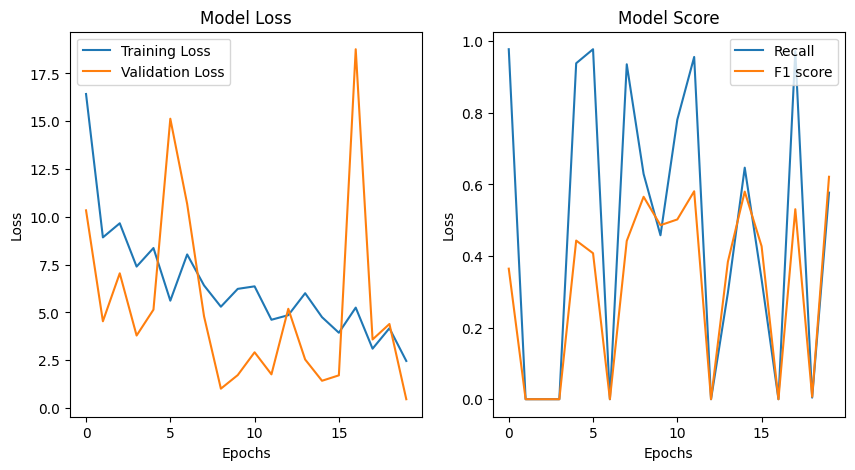

In [34]:
# MLP 그래프
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(MLP_history.history['loss'], label='Training Loss')
plt.plot(MLP_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(MLP_history.history['val_recall'], label='Recall')
plt.plot(MLP_history.history['val_f1_score'], label='F1 score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Score')
plt.legend()
plt.show()

이번에는 CNN 모델을 활용해봅니다.

#### [TODO] CNN 모델 구현하기

In [35]:
# 1D CNN 모델 구성
CNN = Sequential()  # Sequential 모델 생성

# Convolutional layer 추가
CNN.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# MaxPooling 레이어 추가
CNN.add(MaxPooling1D(pool_size=2))
# pool_size=2는 MaxPooling을 2개씩 묶어서 진행

# 데이터를 1차원으로 평탄화
CNN.add(Flatten())

# Fully Connected 레이어 추가
CNN.add(Dense(128, activation='relu'))
CNN.add(Dense(64, activation='relu'))

# 출력 레이어 추가
CNN.add(Dense(1, activation='sigmoid'))

# CNN 모델 요약 정보 출력
CNN.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             6400      
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                      

In [36]:
# 모델 컴파일
CNN.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(),metrics=[recall,f1_score])

In [37]:
# 모델 학습
CNN_history = CNN.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
727/727 [==============================] - 12s 8ms/step - loss: 7.0324 - recall: 0.3591 - f1_score: 0.1899 - val_loss: 5.1259 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/20
727/727 [==============================] - 4s 5ms/step - loss: 4.3776 - recall: 0.3900 - f1_score: 0.2198 - val_loss: 8.7224 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/20
727/727 [==============================] - 4s 5ms/step - loss: 3.6372 - recall: 0.4249 - f1_score: 0.2487 - val_loss: 0.7389 - val_recall: 0.4907 - val_f1_score: 0.5047
Epoch 4/20
727/727 [==============================] - 4s 6ms/step - loss: 2.8588 - recall: 0.4576 - f1_score: 0.2937 - val_loss: 0.9621 - val_recall: 0.4188 - val_f1_score: 0.4901
Epoch 5/20
727/727 [==============================] - 5s 7ms/step - loss: 2.8848 - recall: 0.4774 - f1_score: 0.3207 - val_loss: 7.8461 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 6/20
727/727 [==============================] - 5s 6ms/step - loss: 2

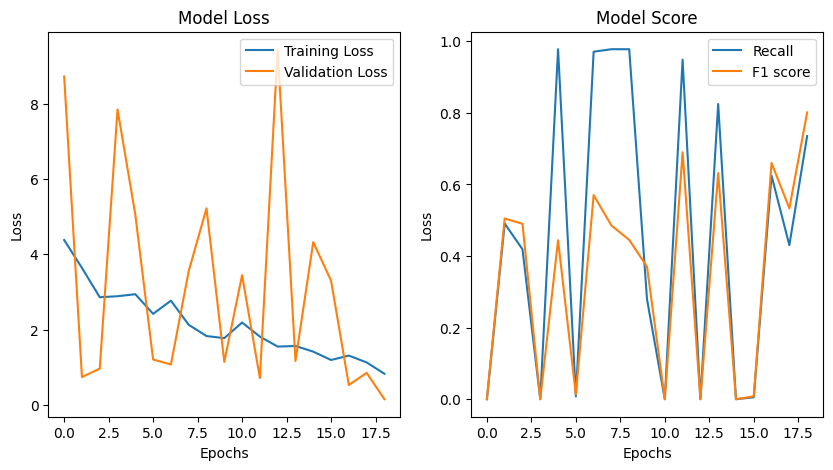

In [38]:
# CNN 그래프
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(CNN_history.history['loss'][1:], label='Training Loss')
plt.plot(CNN_history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(CNN_history.history['val_recall'][1:], label='Recall')
plt.plot(CNN_history.history['val_f1_score'][1:], label='F1 score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Score')
plt.legend()
plt.show()

한번 Bidirectional LSTM 모델을 활용해서도 진행해보도록 하겠습니다.

In [39]:

LSTM = Sequential([

    layers.Bidirectional(tf.keras.layers.LSTM(64)),

    layers.Dense(64, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])


#### [TODO] 모델 compile 및 학습하기

In [40]:
# 모델 컴파일
LSTM.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(),metrics=[recall,f1_score])
# 모델 학습
LSTM_history = LSTM.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
727/727 [==============================] - 14s 9ms/step - loss: 0.3095 - recall: 8.0238e-04 - f1_score: 8.9409e-04 - val_loss: 0.2540 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/20
727/727 [==============================] - 6s 8ms/step - loss: 0.2416 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.2303 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/20
727/727 [==============================] - 7s 9ms/step - loss: 0.2258 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.2176 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/20
727/727 [==============================] - 5s 7ms/step - loss: 0.2142 - recall: 0.0268 - f1_score: 0.0328 - val_loss: 0.2016 - val_recall: 0.4319 - val_f1_score: 0.4823
Epoch 5/20
727/727 [==============================] - 7s 10ms/step - loss: 0.2073 - recall: 0.3431 - f1_score: 0.4213 - val_loss: 0.2049 - val_recall: 0.2224 - val_f1_score: 0.2890
Epoch 6/20
727/727 [==============================

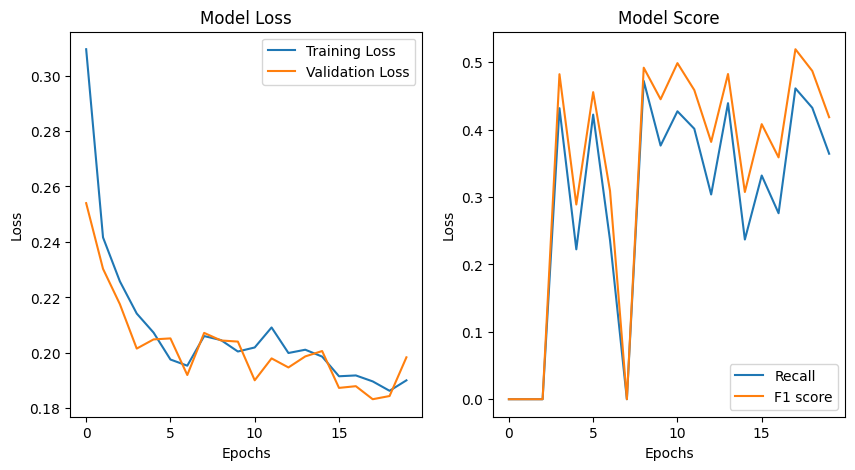

In [41]:
# LSTM 그래프
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(LSTM_history.history['loss'], label='Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(LSTM_history.history['val_recall'], label='Recall')
plt.plot(LSTM_history.history['val_f1_score'], label='F1 score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Score')
plt.legend()
plt.show()


## 4. 모델 성능비교

앞서 살펴본 모델 역시 성능 비교를 해보도록 하겠습니다.


In [42]:
# 테스트 데이터로 예측
# X_test 데이터를 사용하여 MLP 모델이 예측한 결과를 얻습니다.
y_pred = MLP.predict(X_test)[:,0]

# 예측 결과 평가
MLP_recall = recall(y_test, y_pred)
MLP_f1 = f1_score(y_test, y_pred)

# 테스트 데이터로 예측
# X_test 데이터를 사용하여 CNN 모델이 예측한 결과를 얻습니다.
y_pred = CNN.predict(X_test)[:,0]

# 예측 결과 평가
CNN_recall = recall(y_test, y_pred)
CNN_f1 = f1_score(y_test, y_pred)

# 테스트 데이터로 예측
# X_test 데이터를 사용하여 LSTM 모델이 예측한 결과를 얻습니다.
y_pred = LSTM.predict(X_test)[:,0]

# 예측 결과 평가
LSTM_recall = recall(y_test, y_pred)
LSTM_f1 = f1_score(y_test, y_pred)


312/312 [==============================] - 2s 3ms/step


#### [TODO] 최종결과 시각화하기
이렇게 진행한 모델의 학습 결과를 시각화해봅니다.
Recall과 F1 score 값을 기준으로 비교하는 시각화를 그려보도록 하겠습니다.

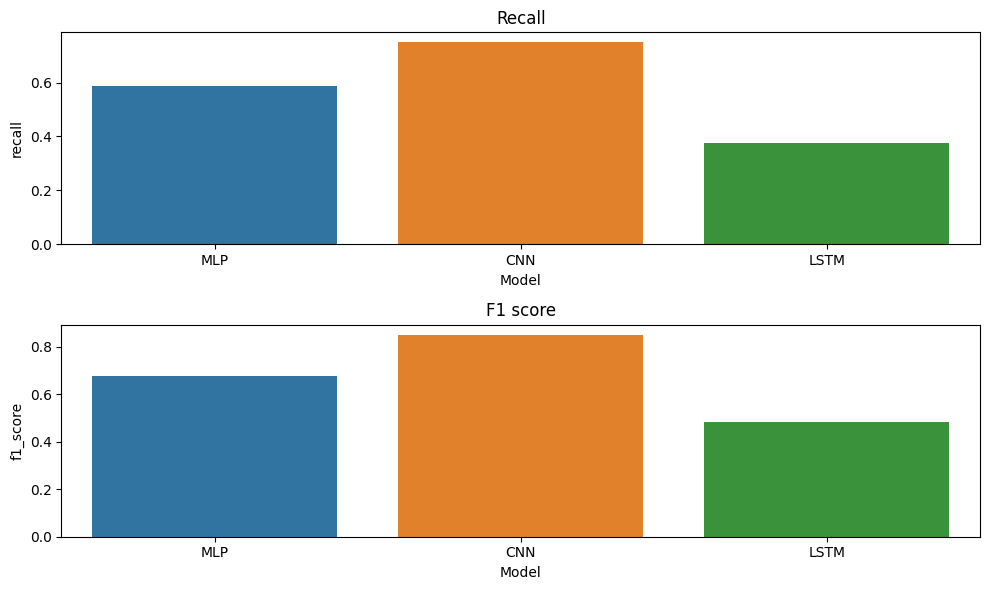

In [47]:
# 딥러닝 모델 별 성능 비교
models = ['MLP', 'CNN', 'LSTM']
_recall = [i.numpy() for i in [MLP_recall,CNN_recall,LSTM_recall]]  # 임의의 평균 제곱 오차 값
_f1 = [i.numpy() for i in [MLP_f1,CNN_f1,LSTM_f1]]   # 임의의 평균 절대 오차 값

# 평가 지표 데이터를 데이터프레임으로 정리
import pandas as pd
data = {'Model': models, 'recall': _recall, 'f1_score': _f1}
df_scores = pd.DataFrame(data)

# 성능 지표를 시각화
plt.figure(figsize=(10, 6))

# 재현율 (recall)
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='recall', data=df_scores)
plt.title('Recall')

# f1_score
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='f1_score', data=df_scores)
plt.title('F1 score')

plt.tight_layout()
plt.show()


해당 결과를 봤을때, CNN이 가장 사용하기에 적절해보입니다. 실제 업무에 활용되기 위해서는 실행 속도, 정답률 등을 상황에 맞게 고려하여 다양한 모델을 실험해보고 선택하여야 하겠습니다.    

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>